In [792]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import gc

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import * 
from tensorflow.keras.utils import *
from tensorflow.keras.optimizers import *

# !pip install efficientnet -q
import efficientnet.tfkeras as efn
import gc

from sklearn.cluster import KMeans
from matplotlib_venn import venn2

# Data

In [264]:
df = pd.read_csv('/Users/dph/downloads/data-deepfake98493/metadata.csv')
def add_prefix(p):
    return os.path.join('/Users/dph/downloads/data-deepfake98493/', p)
def change_label(l):
    return ['REAL', 'FAKE'].index(l)
df['path'] = list(map(add_prefix, df['name_path'].values))
df['label'] = list(map(change_label, df['label'].values))

In [265]:
# the add_path is correct
print(df.loc[0, 'name_path'])
print(df.loc[0, 'path'])

dfdc_train_part_43/vhphtddasg.jpg
/Users/dph/downloads/data-deepfake98493/dfdc_train_part_43/vhphtddasg.jpg


In [266]:
# balance
real_df = df[df.label==0]
fake_df = df[df.label==1].sample(len(real_df))
print(len(real_df), len(fake_df))

# shuffle
train_df = shuffle(pd.concat([real_df, fake_df]))
test_df = df[~df.index.isin(train_df.index)]


# split
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(len(train_df), len(val_df), len(test_df))

16074 16074
25718 6430 66345


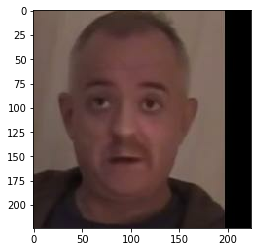

In [267]:
# display one image
def prepocess(x):
    x = tf.io.read_file(x)
    x = tf.image.decode_jpeg(x, channels=3)
    if x.shape != (224, 224, 3):
        x = tf.image.resize(x, [224,224])
    x = tf.cast(x, dtype=tf.float32)/255.
    return x

img=prepocess(df.loc[0, 'path'])
plt.imshow(img)

# EfficientNet

In [752]:
def build_model():
    base = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg') 
    x = Dense(1, activation='sigmoid')(base.output)
    return Model(inputs=base.input, outputs=x)

model = build_model()
# plot_model(model_efn)

In [753]:
# model.summary()

In [754]:
def freeze_until(model, name):
    flag = False
    for l in model.layers:
        if l.name == name:
            flag = True
        l.trainable = flag
freeze_until(model, 'top_conv')

In [755]:
def show_trainable_layers(model):
    for l in model.layers:
        if l.trainable:
            print(l.name)
show_trainable_layers(model)

top_conv
top_bn
top_activation
avg_pool
dense_13


In [724]:
# test preds
x = list(map(prepocess, train_df.loc[:9, 'path']))
preds = model(tf.convert_to_tensor(x))
preds

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.9004384 ],
       [0.53362995],
       [0.90620595],
       [0.16637325],
       [0.76051265],
       [0.463761  ],
       [0.42982107],
       [0.27642882],
       [0.06010089],
       [0.20635585]], dtype=float32)>

In [363]:
layer_outputs = [layer.output for layer in model.layers[:16]] #前16层输出
layer_outputs

[<tf.Tensor 'input_7:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'stem_conv_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'stem_bn_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'stem_activation_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'block1a_dwconv_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'block1a_bn_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'block1a_activation_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'block1a_se_squeeze_6/Identity:0' shape=(None, 48) dtype=float32>,
 <tf.Tensor 'block1a_se_reshape_6/Identity:0' shape=(None, 1, 1, 48) dtype=float32>,
 <tf.Tensor 'block1a_se_reduce_6/Identity:0' shape=(None, 1, 1, 12) dtype=float32>,
 <tf.Tensor 'block1a_se_expand_6/Identity:0' shape=(None, 1, 1, 48) dtype=float32>,
 <tf.Tensor 'block1a_se_excite_6/Identity:0' shape=(None, 112, 112, 48) dtype=float32>,
 <tf.Tensor 'bl

In [364]:
activation_model = Model(inputs=model.input, outputs=layer_outputs) #构建能够输出前16层的模型

In [365]:
activations = activation_model.predict(tf.expand_dims(img, 0), steps=1)

In [366]:
activations[0].shape

(1, 224, 224, 3)

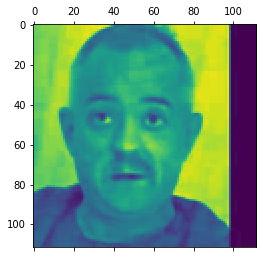

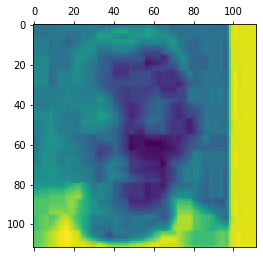

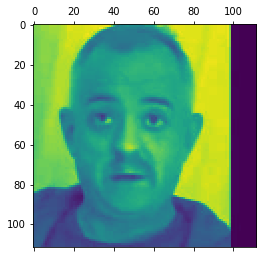

In [367]:
plt.matshow(activations[1][0,:,:,0], cmap='viridis') #第1卷积层的第1特征层输出
plt.matshow(activations[1][0,:,:,1], cmap='viridis')
plt.matshow(activations[1][0,:,:,2], cmap='viridis')

/Users/dph/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


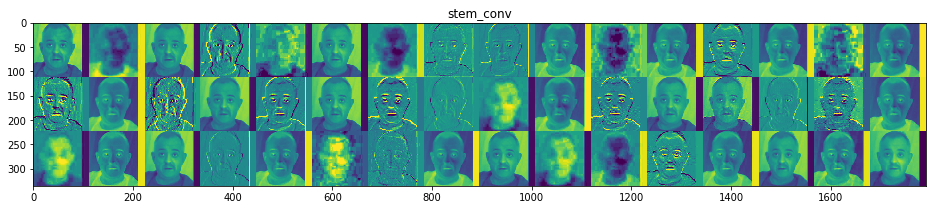

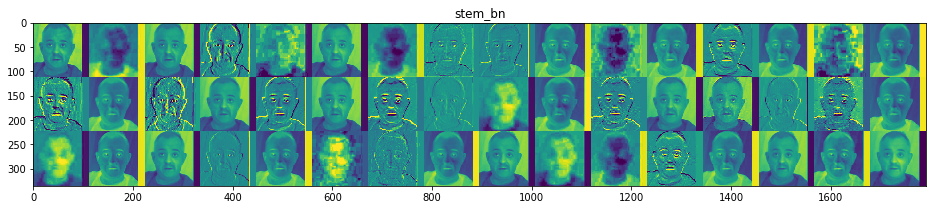

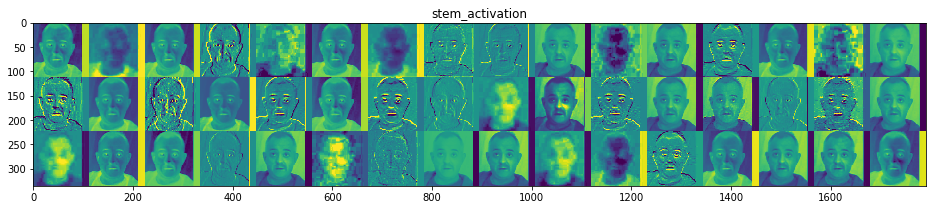

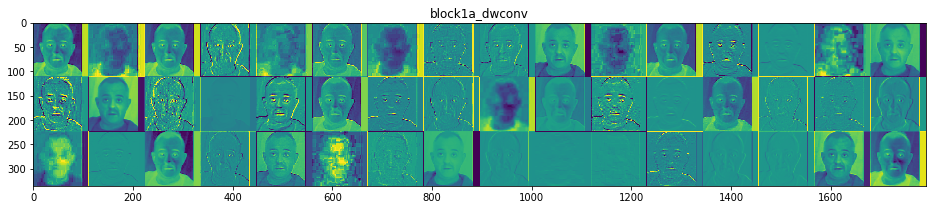

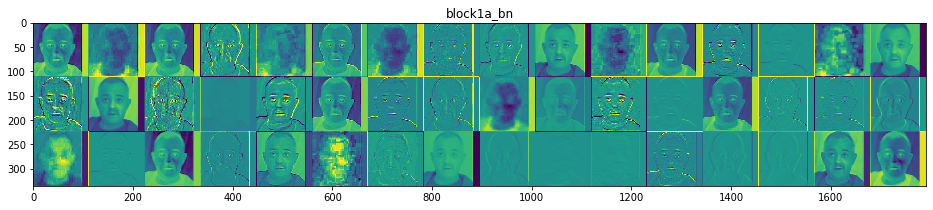

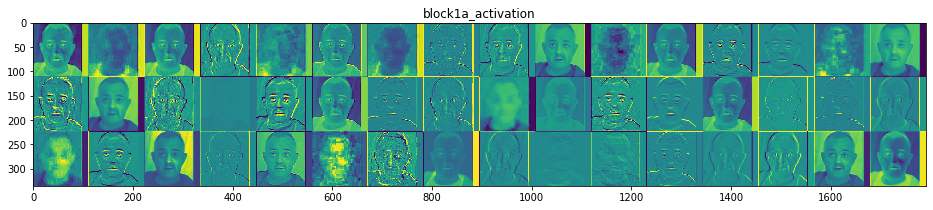

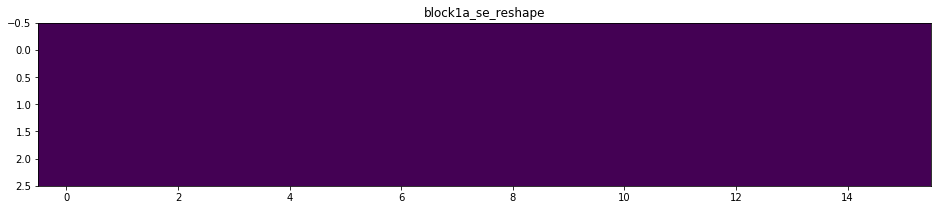

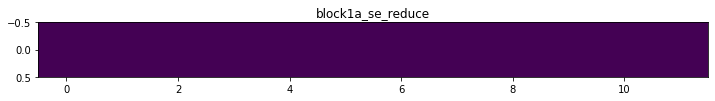

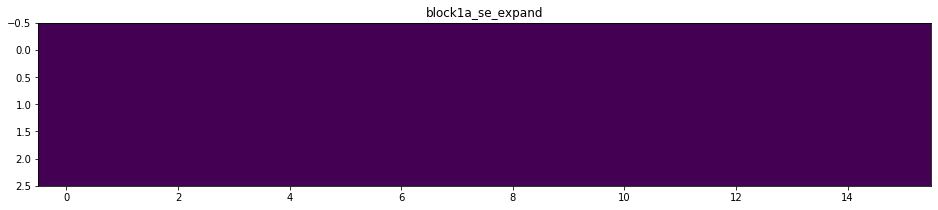

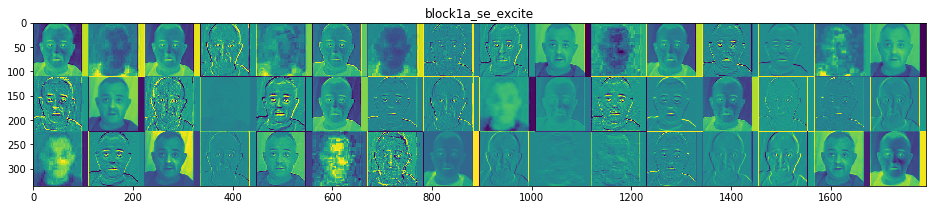

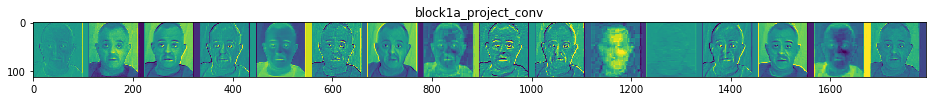

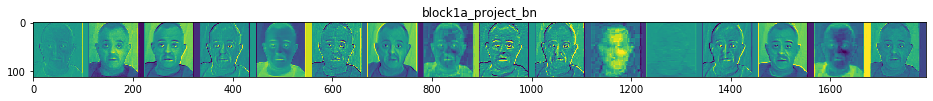

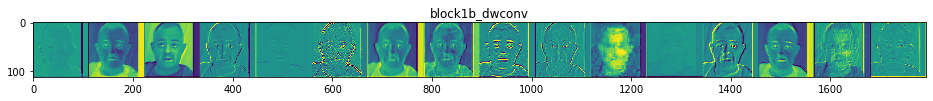

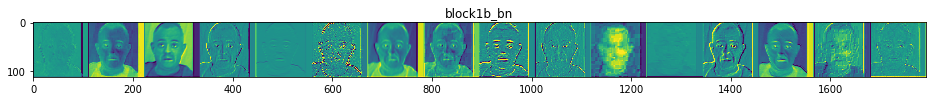

In [368]:
layer_names = []
for layer in model.layers[:16]:
    layer_names.append(layer.name) #特征层的名字

images_per_row=16

for layer_name, layer_activation in zip (layer_names[1:16], activations[1:16]):
    n_feature = layer_activation.shape[-1] # 每层输出的特征层数
    
    if n_feature < 16:
        images_per_row = n_feature
    else:
        images_per_row = 16
        

    size = layer_activation.shape[1]  #每层的特征大小
    n_cols = n_feature//images_per_row #特征图平铺的行数
    display_grid = np.zeros((size*n_cols, images_per_row*size)) # 每层图片大小
    
    if len(layer_activation.shape) != 4:
        continue
    for col in range(n_cols): #行扫描
        for row in range (images_per_row): #平铺每行
            channel_image = layer_activation[0,:,:,col*images_per_row+row] # 写入col*images_per_row+row特征层
            channel_image -= channel_image.mean() #标准化处理，增加可视化效果
            channel_image /= channel_image.std()
            channel_image *=64
            channel_image +=128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # print(channel_image.shape)
            # print(display_grid[col*size:(col+1)*size, row*size:(row+1)*size].shape)
            display_grid[col*size:(col+1)*size, row*size:(row+1)*size] = channel_image #写入大图中
    scale = 1./size #每组图缩放系数
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Training

In [790]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optim = tf.keras.optimizers.Adam(learning_rate=0.01)
# optim = tf.keras.optimizers.SGD(learning_rate=0.01)
scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 2, verbose=1, )

# Dataset

In [756]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'].values[:1000], train_df['label'].values[:1000])).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'].values[:10], val_df['label'].values[:10])).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_df['path'].values[:10], test_df['label'].values[:10])).batch(32)

In [788]:
def train_process(x, y):
    imgs = []
    for i in range(len(x)):
        img = tf.io.read_file(x[i].numpy())
        img = tf.image.decode_jpeg(img, channels=3)
        p = np.random.rand(1)
        if p > 0.5:
            img = tf.image.flip_left_right(img)
        img = tf.cast(img, dtype=tf.float32)/255.
        imgs.append(img)
    imgs = tf.convert_to_tensor(imgs)
    
    return imgs, y

In [789]:
for x, y in val_ds:
    x, y = train_process(x, y)
    print(x.shape, y.shape)
    break

(10, 224, 224, 3) (10,)


In [759]:
# Tensorboard
train_log = os.path.join('./logs/', datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S'), 'train')
train_sw = tf.summary.create_file_writer(train_log)
val_log = os.path.join('./logs/', datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S'), 'val')
val_sw = tf.summary.create_file_writer(val_log)

In [760]:
!ls

dfdc-EfficientNet-TF.ipynb logs


In [761]:
def train_on(epoch):
    loss_t = []
    for i, (x, y) in enumerate(train_ds):
        x, y = train_process(x, y)
        with tf.GradientTape() as tape:
            preds = model(x, training=True)
            loss = loss_fn(y, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        
#         # show grads
        b = model.layers[-1].trainable_weights[0].numpy()
        b_grad = grads[0].numpy()
        print('pred', tf.round(tf.squeeze(preds)), y)
        print(b_grad)
        
        optim.apply_gradients(zip(grads, model.trainable_variables))
            
        loss_t.append(loss.numpy())
        history['train_loss'].append(loss.numpy())
        if i % 1 == 0:
            print('Epoch: %d, Step: %d, Loss: %2f' % (epoch, i, loss.numpy()))
            
        del grads, preds, loss
        gc.collect()

    with train_sw.as_default():
        tf.summary.scalar('loss', np.mean(loss_t), step=epoch)

In [762]:
def val_on(epoch):
    loss = 0
    num = 0
    for i, (x, y) in enumerate(val_ds):
        x, y = train_process(x, y)
        preds = model(x)
        loss += loss_fn(y, preds)*x.shape[0]
        num += x.shape[0]
        print('val', tf.round(tf.squeeze(preds)), y)
#     with val_sw.as_default():
#         tf.summary.scalar('loss', loss/num, step=epoch)
        
    history['val_loss'].append(loss/num)
    
    print('Epoch: %d, Val loss: %2f' % (epoch, loss/num))

In [763]:
history = {'train_loss': [], 'val_loss': []}

def train(epochs):
    for e in range(epochs):
        train_on(e)
        val_on(e)
        print('\n\n')

In [764]:
train(10)

pred tf.Tensor(
[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1], shape=(32,), dtype=int64)
[[[[ 2.0085904e-04 -5.3292097e-05 -6.4999529e-04 ... -1.1800183e-06
    -3.0035025e-04 -1.1017143e-03]
   [ 4.1460420e-04 -1.3466123e-04 -8.9514349e-04 ...  1.5718656e-06
     1.7913880e-03 -1.3138504e-03]
   [-4.5148435e-04 -4.0868517e-06  2.5027673e-04 ... -1.3163028e-06
    -3.7161552e-04  1.2366872e-03]
   ...
   [ 2.4453679e-04 -1.8300156e-05 -2.0027437e-04 ... -5.3533893e-07
     4.4378481e-04  2.1803862e-04]
   [ 9.5132017e-04 -8.3507417e-05 -5.7684461e-04 ...  2.2116542e-06
     1.0239466e-03 -2.7886750e-03]
   [ 1.4020938e-03 -4.8606162e-05  6.9579270e-05 ...  9.8793703e-07
     5.5036752e-04  9.7623561e-04]]]]
Epoch: 0, Step: 0, Loss: 0.702113
pred tf.Tensor(
[0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 0

pred tf.Tensor(
[0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1], shape=(32,), dtype=int64)
[[[[ 2.25309166e-04  1.52720910e-04  4.78714501e-05 ... -4.30361426e-04
     9.14882185e-06 -1.73812296e-05]
   [-9.05501292e-05 -3.49310139e-04 -1.72123167e-04 ...  4.26602055e-04
    -2.03263753e-05 -8.32121514e-05]
   [ 6.70575173e-05 -2.62444722e-04  2.20322880e-04 ... -2.39460889e-04
    -1.04022176e-04  3.45851186e-05]
   ...
   [-2.99675739e-04  1.53488363e-04 -6.89845940e-04 ...  1.41185673e-03
     9.17902871e-05  7.73847496e-05]
   [-2.75070051e-04 -4.14775423e-04 -7.27505540e-04 ...  1.42267824e-03
     1.52960216e-04 -1.17106545e-04]
   [-2.95979960e-04  1.48940962e-04  8.19971901e-05 ... -6.99567317e-05
     7.64679571e-05  1.01624406e-04]]]]
Epoch: 0, Step: 9, Loss: 1.227824
pred tf.Tensor(
[1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.

pred tf.Tensor(
[0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1], shape=(32,), dtype=int64)
[[[[-1.23682548e-04  1.66926634e-06 -2.62309273e-04 ...  2.14895525e-04
     1.81586249e-04 -1.06621570e-04]
   [ 1.35564143e-04  1.67952589e-06  7.50041727e-06 ... -4.63058241e-05
    -1.02218301e-05 -2.00616108e-04]
   [ 3.73128220e-04 -2.17086267e-06 -7.64933357e-05 ...  1.06259984e-04
     1.33708876e-04  1.27025080e-04]
   ...
   [ 7.05759703e-06 -4.55706686e-06 -1.78851144e-04 ...  7.16275536e-05
    -3.02502958e-05  3.88444401e-04]
   [ 1.25840027e-03  1.32169794e-06  1.72151951e-04 ... -1.65209698e-04
    -1.14785376e-04 -1.00338992e-04]
   [-2.97864288e-04 -3.98821749e-06 -3.05128306e-05 ...  5.59910186e-05
     2.73111364e-05  3.79538367e-04]]]]
Epoch: 0, Step: 18, Loss: 0.996380
pred tf.Tensor(
[1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0

pred tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1], shape=(32,), dtype=int64)
[[[[ 6.0701677e-05  3.6737489e-05 -4.4922137e-05 ...  1.0667794e-05
     2.2330445e-05 -2.0692711e-05]
   [-1.1702519e-05  1.9218227e-05 -2.9693150e-05 ...  3.3105339e-06
    -7.2465053e-05 -8.5076335e-06]
   [-3.1132076e-06 -5.3243013e-05  4.4906545e-05 ... -5.8534883e-06
     4.4674744e-06  1.5675418e-05]
   ...
   [ 9.8770441e-05 -1.8513278e-04 -2.0421798e-05 ... -1.4299356e-05
    -3.2453667e-05 -3.4553981e-05]
   [-9.6374570e-06  2.0635007e-04 -5.6884928e-05 ...  6.1784522e-07
    -1.1950123e-04 -8.0249420e-06]
   [ 1.4231693e-04 -8.0824437e-05 -6.8457644e-05 ...  2.3393595e-06
    -4.0249688e-06  5.5440167e-05]]]]
Epoch: 0, Step: 27, Loss: 0.797210
pred tf.Tensor(
[0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 

pred tf.Tensor(
[1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1], shape=(32,), dtype=int64)
[[[[-6.2212166e-06 -2.0503678e-05 -7.1658193e-05 ... -1.5165467e-06
    -1.4718295e-05  5.6530998e-06]
   [ 6.4922228e-06 -3.3036154e-05 -1.8773204e-05 ... -6.4688305e-07
     3.8117241e-06  8.6565876e-07]
   [ 1.5059657e-06  2.5082682e-05 -4.5853209e-05 ... -1.6479497e-06
    -3.9612823e-06 -7.2290200e-06]
   ...
   [ 7.2604325e-06  3.4302444e-05  7.0272290e-05 ... -3.4206494e-08
    -1.4049654e-05  6.5522227e-06]
   [ 4.2742056e-05 -6.6027678e-06 -9.2590948e-05 ... -1.1281411e-06
    -9.9180252e-05  3.4530281e-06]
   [-3.6221765e-05  2.0872038e-05  3.1527161e-05 ...  3.5334372e-07
     1.8015886e-05 -1.3656219e-05]]]]
Epoch: 1, Step: 4, Loss: 0.737087
pred tf.Tensor(
[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1

pred tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0], shape=(32,), dtype=int64)
[[[[ 4.36978080e-05  8.52741232e-06 -1.73517656e-05 ...  1.56128863e-05
    -4.50833522e-06 -6.89889785e-05]
   [-2.58600467e-05  1.07593660e-05  2.22150629e-05 ... -4.91967626e-07
    -8.24423387e-06 -8.82618406e-06]
   [-5.69999866e-05 -8.23992013e-06 -5.02080147e-05 ... -1.81842734e-05
    -7.54740358e-06 -7.86656165e-05]
   ...
   [ 9.78648459e-05  1.37021525e-05 -1.11171335e-04 ... -1.73619846e-05
    -4.08521691e-06 -9.81870326e-05]
   [-1.74540357e-04  3.28967144e-06  2.30232792e-04 ...  2.32975908e-05
     1.81155156e-05  7.00634846e-05]
   [ 2.06477300e-04 -8.15802559e-06 -6.53964089e-05 ... -3.27609814e-06
    -1.38908472e-05  2.99263775e-06]]]]
Epoch: 1, Step: 13, Loss: 0.777365
pred tf.Tensor(
[0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0

pred tf.Tensor(
[1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1], shape=(32,), dtype=int64)
[[[[ 2.48494907e-04  1.35693099e-05  5.60020417e-05 ... -4.59033909e-05
    -6.28015696e-05  4.87597572e-06]
   [ 1.10433466e-04  9.69403027e-06 -1.20173136e-05 ...  2.11580100e-05
     7.73551801e-06  6.67472159e-06]
   [-9.75175208e-05  1.01002761e-05  3.92960919e-06 ... -1.69717805e-06
     7.31254295e-06  4.69742645e-06]
   ...
   [-1.40195436e-04  7.04314425e-06 -3.74664342e-05 ...  1.38910509e-05
    -5.22780738e-06  8.05021955e-06]
   [ 2.02883049e-04  1.52045777e-05 -1.59972606e-05 ...  1.96919736e-05
     3.82828111e-05 -2.41362500e-06]
   [-4.70302359e-04 -1.32067717e-05 -2.16297067e-05 ...  5.66417384e-06
    -6.38115398e-06 -3.24725670e-06]]]]
Epoch: 1, Step: 22, Loss: 0.861520
pred tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0

pred tf.Tensor([0. 1. 0. 1. 1. 1. 0. 1.], shape=(8,), dtype=float32) tf.Tensor([0 1 1 0 1 1 0 1], shape=(8,), dtype=int64)
[[[[ 2.38035587e-04 -1.03627190e-06 -3.26846566e-06 ... -2.94777419e-05
    -8.63788591e-06  3.39442835e-04]
   [-2.26900316e-04 -6.87424199e-06 -2.03678087e-06 ...  2.77038089e-06
     5.30732359e-05 -1.17243835e-04]
   [-9.00219020e-05 -7.68301470e-06  1.15423263e-05 ...  4.07042535e-05
     6.72437527e-05 -1.80314091e-05]
   ...
   [ 4.24352475e-05  3.91450340e-06  5.01801742e-06 ...  4.17204355e-05
    -1.59347128e-05 -2.84527341e-05]
   [ 1.52183551e-04 -7.68997779e-07  3.66612767e-08 ...  1.32239638e-05
     4.27162304e-05  2.65328708e-04]
   [ 8.09990379e-05  2.94619417e-06 -5.14536850e-06 ... -1.96262727e-06
    -1.82141339e-05  1.47200481e-04]]]]
Epoch: 1, Step: 31, Loss: 0.411600
val tf.Tensor([1. 1. 1. 0. 1. 1. 1. 1. 0. 1.], shape=(10,), dtype=float32) tf.Tensor([0 0 1 1 0 1 1 1 0 0], shape=(10,), dtype=int64)
Epoch: 1, Val loss: 1.852403



pred tf.Tens

pred tf.Tensor(
[1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1], shape=(32,), dtype=int64)
[[[[-3.46160610e-04  3.08529525e-06  2.11720944e-05 ...  1.10162491e-05
    -5.58655711e-06 -1.09857298e-04]
   [ 5.97905782e-05 -1.08327538e-06 -1.82180374e-05 ... -1.17543077e-05
     2.15345881e-06  6.34383759e-05]
   [-3.36560843e-05  3.66088784e-07 -1.26469040e-05 ... -2.96986877e-06
    -3.02046192e-06 -2.24628864e-04]
   ...
   [ 1.51556742e-05  1.86714328e-06 -3.42401381e-06 ... -4.14933493e-06
    -8.05998116e-06  1.01002275e-04]
   [ 2.80081062e-04  1.00593957e-06  2.57911415e-05 ...  6.46058561e-06
     3.69287136e-06  1.72401342e-04]
   [ 7.73290230e-05  2.25060649e-06  1.78207301e-06 ...  6.84110319e-06
     4.02316346e-06  3.10884498e-05]]]]
Epoch: 2, Step: 8, Loss: 0.729462
pred tf.Tensor(
[1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1.

pred tf.Tensor(
[0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1], shape=(32,), dtype=int64)
[[[[-1.16792326e-04  2.73180035e-07 -3.47663808e-05 ... -4.07882981e-05
    -4.98873123e-06 -9.66408625e-05]
   [-2.94313213e-06 -1.09470818e-06  3.12550401e-05 ...  1.71196552e-05
    -5.02297189e-06 -2.83663394e-05]
   [-1.35589682e-04  1.09582140e-06 -3.58553698e-05 ... -2.89669533e-05
     2.57813099e-06 -8.40570647e-05]
   ...
   [ 2.04314521e-04 -3.54068959e-07  4.55315676e-05 ...  3.35600125e-05
     1.88376089e-06 -6.93571474e-06]
   [ 1.28329440e-04  1.37133156e-06  4.85614291e-05 ...  3.26324553e-05
     4.06725121e-06  1.93719279e-06]
   [-1.77590380e-04  2.12396617e-06 -3.14165554e-05 ... -1.53512028e-05
     8.24727340e-06 -1.97673762e-05]]]]
Epoch: 2, Step: 17, Loss: 0.534470
pred tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

pred tf.Tensor(
[1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1], shape=(32,), dtype=int64)
[[[[-1.0287822e-04  2.1219269e-06 -3.5747032e-06 ... -7.9913661e-07
    -1.8111492e-05  2.3451834e-05]
   [ 3.2427895e-05  1.5215438e-06  9.8612554e-07 ... -6.3318762e-06
     1.9411118e-08  8.8851230e-06]
   [-3.8816492e-05  1.1091621e-06 -1.0557081e-05 ...  1.8049752e-05
     2.8896324e-05 -1.6689692e-05]
   ...
   [ 5.7295387e-05  1.8453076e-06 -1.7331217e-06 ...  6.0967709e-06
    -8.7437038e-06  1.6628899e-05]
   [ 1.6131651e-04 -1.2544605e-06  2.1267874e-07 ... -6.0742113e-06
     1.4542266e-05  2.2721313e-05]
   [ 1.7393300e-05 -6.2920340e-06  4.2351121e-06 ...  4.1970188e-06
     2.2276970e-05  2.2601156e-05]]]]
Epoch: 2, Step: 26, Loss: 0.674962
pred tf.Tensor(
[0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 

pred tf.Tensor(
[0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0], shape=(32,), dtype=int64)
[[[[-3.6121335e-05 -8.4961630e-06  5.5358560e-06 ...  2.7812166e-07
     2.2105185e-05 -2.6127591e-05]
   [-2.2041097e-05 -4.3435607e-06 -1.4834942e-05 ...  9.4486732e-06
     1.5435158e-05 -5.1843404e-06]
   [ 9.0393325e-05 -6.7093383e-06  3.8747785e-06 ... -1.6739799e-05
    -2.3266402e-05  1.2308565e-05]
   ...
   [-5.0390481e-05 -5.9361209e-06 -2.9043080e-05 ... -1.6022037e-05
     3.0593015e-05 -1.1220559e-05]
   [ 2.2822058e-05  8.3312316e-06 -7.3577314e-05 ... -2.3616434e-05
    -1.4463886e-05 -1.2051677e-05]
   [-1.3622825e-04 -2.2884833e-06  4.4124579e-05 ...  1.3885413e-05
     1.0002568e-05 -5.6724712e-06]]]]
Epoch: 3, Step: 3, Loss: 0.682426
pred tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 0

pred tf.Tensor(
[1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0], shape=(32,), dtype=int64)
[[[[ 7.67398888e-05  2.45271622e-06 -4.21081204e-05 ... -1.60972249e-05
    -5.19655714e-06 -1.43470588e-05]
   [ 8.86621347e-05  5.53979089e-06 -2.64686441e-05 ... -1.79237686e-05
    -6.14423379e-06 -8.68701250e-07]
   [-5.17535300e-05 -1.44999785e-06 -7.84964050e-06 ... -2.14951069e-06
    -9.17641501e-07 -1.85301360e-06]
   ...
   [-1.19574055e-04  3.60204649e-06  1.95499160e-05 ...  9.54739244e-06
    -1.13941223e-06  1.74494489e-05]
   [-1.46891573e-04  3.81339692e-06  3.12108023e-05 ...  3.37880410e-05
     5.78116214e-06  7.15550414e-06]
   [-5.15393949e-05  2.91669653e-06  1.50247888e-05 ... -5.35032814e-06
    -6.51504160e-06  2.91732158e-05]]]]
Epoch: 3, Step: 12, Loss: 0.493253
pred tf.Tensor(
[1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1

pred tf.Tensor(
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1], shape=(32,), dtype=int64)
[[[[ 8.89026123e-05 -4.10708253e-06 -2.55842480e-07 ... -1.32720470e-05
    -3.49937582e-05  3.85746171e-05]
   [ 1.29453165e-05 -6.51751748e-07 -1.55435282e-06 ... -4.82732030e-05
    -1.57237464e-05 -8.59905776e-06]
   [-4.98023583e-05  2.38836662e-07  4.20009110e-06 ...  3.17153281e-05
     7.01231284e-06 -2.50398043e-05]
   ...
   [-2.98935556e-05 -1.63590425e-06  1.44440764e-05 ...  8.27465628e-05
     1.99213036e-06 -4.19858907e-06]
   [-2.75395942e-05  4.45251681e-06  1.71329229e-05 ...  7.76485467e-05
     3.47865971e-05 -5.09876554e-06]
   [ 7.86805176e-05 -2.05260994e-06 -1.67145245e-05 ...  1.72330074e-05
    -8.04294450e-06  2.05107808e-05]]]]
Epoch: 3, Step: 21, Loss: 0.699842
pred tf.Tensor(
[0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1

pred tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 0], shape=(32,), dtype=int64)
[[[[ 1.73987482e-05  2.43171871e-06  5.91480693e-06 ...  6.87628199e-05
     1.01055703e-05 -3.96150135e-05]
   [-3.31735464e-06 -1.15575506e-06 -3.69035843e-06 ...  1.64679877e-05
    -1.70373241e-05 -3.69688423e-05]
   [ 1.99228634e-05 -3.79641415e-06  1.70636849e-06 ...  3.51720955e-05
     7.51838115e-06  1.33771937e-06]
   ...
   [-1.33241219e-05 -1.80132781e-06  9.09202754e-06 ... -5.90625496e-06
     3.58742705e-06 -3.38073914e-05]
   [ 3.30445328e-05  1.51151789e-06 -5.32796221e-05 ... -1.20632685e-04
    -1.19977385e-05 -8.31654979e-05]
   [-1.24859671e-05  6.36423783e-06  5.10106838e-06 ...  3.71890710e-05
     4.52727763e-05  1.06741509e-05]]]]
Epoch: 3, Step: 30, Loss: 0.719606
pred tf.Tensor([0. 1. 1. 0. 1. 1. 0. 1.], shape=(8,), 

pred tf.Tensor(
[0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1], shape=(32,), dtype=int64)
[[[[ 1.18246935e-04 -1.31039496e-06  5.24321404e-05 ...  4.55491318e-05
    -2.01849616e-05  6.96552388e-06]
   [ 7.45279322e-05 -7.82742518e-07 -3.48028807e-05 ... -3.56443670e-05
    -1.06983989e-05 -7.77330115e-07]
   [-9.96327890e-06  5.31989690e-06 -6.10861680e-05 ... -2.40884892e-05
     2.81789544e-05 -2.66303996e-05]
   ...
   [-5.38401764e-05 -7.17638557e-07  1.02326034e-04 ...  1.01779187e-04
     1.43101370e-05 -3.67063003e-05]
   [ 7.55813380e-06  7.32175522e-07  5.08151315e-05 ...  2.07513422e-05
     1.59704050e-05 -3.05588474e-05]
   [-5.44030518e-05 -3.49126321e-06  1.94879958e-05 ...  4.49784857e-05
     2.64640603e-05  1.03446928e-05]]]]
Epoch: 4, Step: 7, Loss: 0.535246
pred tf.Tensor(
[1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.

pred tf.Tensor(
[1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0], shape=(32,), dtype=int64)
[[[[-4.9869876e-05 -3.9318297e-06 -6.2918312e-05 ...  3.0535602e-06
     1.4522635e-05 -2.4388582e-05]
   [-4.3669035e-05 -2.5295310e-06  4.5672659e-05 ... -1.3736720e-05
     9.9815488e-06 -4.6428468e-05]
   [-5.0942137e-05 -1.9954218e-06  1.7180628e-05 ...  2.5941144e-05
     1.9671061e-06  8.3894010e-05]
   ...
   [ 8.0941645e-06 -1.2919975e-06 -5.4050188e-06 ...  7.1697534e-05
    -4.4667527e-06  6.6943896e-05]
   [ 4.4229924e-05  1.8887220e-06 -4.6153291e-05 ... -3.3696044e-05
    -3.3378183e-05 -3.0331397e-05]
   [-3.9660576e-05  2.5392319e-06  6.1269573e-05 ...  1.3266894e-05
    -4.2814127e-06  2.5248964e-05]]]]
Epoch: 4, Step: 16, Loss: 0.433530
pred tf.Tensor(
[1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 

pred tf.Tensor(
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0], shape=(32,), dtype=int64)
[[[[-3.94211092e-05 -7.34033165e-06  2.50559478e-05 ...  4.75953711e-05
     4.58893737e-05  2.31550257e-05]
   [ 1.20304925e-04 -4.44200941e-06 -1.72806249e-05 ... -1.22874053e-05
    -2.66843053e-05  2.36895430e-05]
   [ 2.11982842e-04  4.03851072e-06 -3.70503549e-05 ... -4.70759878e-05
    -1.16223273e-05  6.49502763e-05]
   ...
   [ 1.36900853e-05  1.58300963e-06  9.23008156e-06 ... -8.16420652e-07
     1.72014597e-06 -2.79529286e-06]
   [ 1.75839508e-04  1.05638874e-05 -1.31031329e-05 ... -4.51284905e-06
    -1.26483337e-06  4.09944441e-05]
   [ 1.16353294e-04  1.22985302e-05  1.65633173e-05 ... -1.66653172e-06
    -2.73427213e-05  8.35995306e-05]]]]
Epoch: 4, Step: 25, Loss: 0.535287
pred tf.Tensor(
[0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1

pred tf.Tensor(
[0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1], shape=(32,), dtype=int64)
[[[[-4.23720849e-05 -2.41010512e-05  2.63903576e-06 ...  4.20977412e-05
     6.07737347e-05  7.37955197e-05]
   [-8.02367358e-05 -9.31549130e-06  6.98075246e-06 ...  2.46211621e-05
     1.76338326e-05 -9.33022893e-05]
   [ 3.11259617e-04  3.58962789e-05 -1.77136208e-05 ... -1.18318756e-04
    -7.12606270e-05  2.84195587e-04]
   ...
   [ 3.61825165e-04  2.20565198e-05 -2.18937839e-05 ... -2.86202412e-05
    -1.56551432e-05  3.60934791e-06]
   [ 1.18704913e-04 -1.40789525e-05 -3.70042071e-05 ... -6.50443326e-05
    -3.24010543e-05 -8.17140462e-05]
   [ 7.49610845e-05  2.02644078e-05  7.71588748e-06 ...  4.41385691e-06
    -2.18201262e-06  2.03196862e-04]]]]
Epoch: 5, Step: 2, Loss: 0.533800
pred tf.Tensor(
[1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0.

pred tf.Tensor(
[0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1], shape=(32,), dtype=int64)
[[[[-1.9373969e-04  3.0400282e-05  2.4339522e-05 ...  8.6309148e-05
    -1.9333598e-05 -8.0560079e-05]
   [-4.0040708e-05 -1.1203325e-05  2.1203887e-05 ... -3.2453288e-05
    -3.2295588e-07  9.6293388e-07]
   [ 3.0778669e-05 -3.2823514e-06  6.3581297e-07 ... -5.6441735e-05
     4.4638946e-06  1.8294941e-05]
   ...
   [ 1.8027543e-04  5.5412065e-06 -3.2597782e-05 ... -7.2691022e-05
     2.3016914e-06 -2.3979826e-05]
   [-9.9454264e-06  3.2573644e-07  4.0008006e-05 ...  4.7003261e-05
     7.2361140e-06  3.2821448e-05]
   [ 1.8715131e-05  4.3701075e-05 -1.1883782e-05 ... -6.6001165e-05
    -1.7256703e-05  9.8030388e-05]]]]
Epoch: 5, Step: 11, Loss: 0.685529
pred tf.Tensor(
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 

pred tf.Tensor(
[1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0], shape=(32,), dtype=int64)
[[[[ 8.60468572e-05  1.91557010e-05 -5.67551615e-06 ... -1.13237882e-04
    -1.89103903e-05 -3.07648043e-05]
   [-9.73901406e-05  1.35972959e-06  6.99890152e-05 ...  1.68008162e-04
     1.52511639e-05  2.50110024e-05]
   [-2.79769120e-05  1.28962765e-05 -1.43514208e-05 ... -1.48531224e-04
    -9.36667129e-06 -4.34805333e-05]
   ...
   [-1.06219435e-04  1.30905601e-05 -1.99258902e-05 ... -1.74474335e-05
    -1.12252947e-05  7.07105064e-05]
   [ 5.38052554e-05  1.74569850e-05 -4.48721839e-05 ...  1.31555425e-05
    -1.21146513e-06  7.35662470e-05]
   [-2.66382958e-05 -1.06545658e-05 -3.72967588e-05 ... -5.53823775e-05
    -1.59725460e-08 -6.04990892e-05]]]]
Epoch: 5, Step: 20, Loss: 0.638172
pred tf.Tensor(
[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0

pred tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1], shape=(32,), dtype=int64)
[[[[ 4.87283905e-05 -5.66021390e-06  1.51801505e-05 ...  8.75105397e-05
    -3.76711614e-06 -1.36174174e-04]
   [-4.04469683e-05 -1.49160587e-06 -1.32094538e-05 ... -6.40699145e-05
    -5.58947249e-06  3.31418778e-05]
   [ 6.75932752e-05 -1.29120526e-05  2.14771990e-06 ... -1.36293893e-05
     2.05725632e-06 -8.88873328e-05]
   ...
   [-6.39021382e-05 -2.76287210e-07 -3.78236541e-06 ... -3.01741366e-05
     8.79218533e-06  3.82072722e-05]
   [-4.98218178e-05 -2.01640742e-05  1.86376164e-05 ...  8.07348333e-05
     1.42500685e-05 -3.95189381e-05]
   [-3.66716449e-07  2.35466014e-05 -1.22279271e-05 ... -9.90562257e-05
    -8.53569145e-06  1.27338804e-04]]]]
Epoch: 5, Step: 29, Loss: 0.453343
pred tf.Tensor(
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1

pred tf.Tensor(
[0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1], shape=(32,), dtype=int64)
[[[[-3.68370966e-05 -7.52732467e-06  2.65621884e-06 ... -4.47082311e-05
    -2.79320284e-06 -6.52687158e-05]
   [ 2.04411226e-05  7.44853605e-06  3.78114464e-06 ... -1.63817131e-05
    -9.11750794e-06 -8.64425892e-05]
   [-7.33891284e-07  5.33393268e-06 -1.09909024e-05 ...  6.35390606e-05
    -1.46525690e-06  9.09851078e-05]
   ...
   [ 8.62396118e-05 -3.47408786e-08 -1.43944339e-06 ...  1.20589766e-06
    -4.76732839e-06  3.70934722e-05]
   [-2.54463939e-05 -6.08945174e-06  1.16806914e-05 ... -1.90357750e-05
     7.26624967e-06 -1.12229056e-04]
   [ 2.55160139e-05 -7.11008215e-06 -1.04637165e-05 ...  2.53358739e-05
     1.08873337e-05  9.49817040e-05]]]]
Epoch: 6, Step: 6, Loss: 0.586582
pred tf.Tensor(
[1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.

pred tf.Tensor(
[0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1], shape=(32,), dtype=int64)
[[[[-3.2439297e-05 -9.8027012e-06 -1.0412591e-06 ... -1.3305644e-05
     1.8836126e-06  2.6031348e-06]
   [-2.4262225e-05 -8.9559671e-06 -1.3180440e-06 ...  7.6744209e-06
     2.0493810e-06  5.0960007e-06]
   [ 7.8829318e-05 -5.0128551e-07  1.8760638e-06 ...  1.8663004e-05
    -2.7141668e-06 -3.9032318e-05]
   ...
   [ 7.2349823e-05 -1.8432829e-06 -4.5905099e-06 ... -3.4232435e-05
    -1.1442463e-05 -3.0827679e-05]
   [-6.5703534e-05  1.0934992e-05 -5.6324698e-06 ... -1.5459897e-05
    -7.1366649e-06  5.0611976e-05]
   [-4.1188585e-05 -5.7944658e-07  9.8297414e-07 ... -1.5090987e-05
     7.7786844e-06  2.6146527e-05]]]]
Epoch: 6, Step: 15, Loss: 0.390591
pred tf.Tensor(
[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 

pred tf.Tensor(
[0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0], shape=(32,), dtype=int64)
[[[[ 5.02215153e-06 -1.80130868e-07  7.93464096e-06 ...  4.57709066e-05
     1.58657767e-05  8.40950815e-06]
   [ 2.64374376e-05  8.60997716e-06 -6.79452478e-06 ... -1.62710694e-05
    -1.21752619e-05  4.49447361e-06]
   [ 3.74348165e-05  1.78271057e-05 -6.04525212e-08 ...  9.98967698e-06
    -9.62814011e-06  9.82379715e-05]
   ...
   [-4.96545217e-05 -2.96208236e-06  5.49105880e-06 ...  1.16179308e-05
     5.81236600e-06 -4.18871605e-05]
   [ 8.95440535e-05  1.61788303e-05 -2.88940610e-05 ... -7.43689161e-05
    -2.54317019e-05  2.84688394e-05]
   [ 2.31572158e-05  1.37634415e-05  2.19919020e-05 ...  5.89094343e-05
    -5.15045440e-06  3.67649336e-05]]]]
Epoch: 6, Step: 24, Loss: 0.279675
pred tf.Tensor(
[0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0

pred tf.Tensor(
[1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0], shape=(32,), dtype=int64)
[[[[ 4.26416664e-05 -9.98303585e-06  1.09629991e-05 ...  7.57997186e-05
     1.46989460e-05  1.89497696e-05]
   [-1.02261314e-04 -2.17759880e-05 -2.21060191e-06 ... -1.65562960e-05
     9.12484666e-06 -5.60817643e-05]
   [ 3.19818719e-05 -5.70582688e-06 -5.27415841e-06 ... -5.63704489e-05
    -5.56153236e-06  3.37149395e-05]
   ...
   [ 2.38212415e-05  1.05596773e-05  6.82569453e-06 ...  3.98518023e-05
     8.89996045e-06  1.61825028e-05]
   [ 2.05087417e-07 -1.20822733e-05 -1.67222570e-05 ... -6.65280750e-05
    -3.67621469e-05  3.99973505e-05]
   [ 1.05404863e-04  2.11609968e-05  8.09859739e-06 ...  1.34940601e-05
    -1.64164048e-05  1.09811503e-04]]]]
Epoch: 7, Step: 1, Loss: 0.708014
pred tf.Tensor(
[0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.

pred tf.Tensor(
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0], shape=(32,), dtype=int64)
[[[[ 6.3359927e-05 -2.1601316e-05 -4.6637033e-06 ...  9.4704010e-06
     4.5989318e-06 -1.1119417e-05]
   [ 4.8339942e-05  1.9510084e-05 -1.8798615e-05 ...  2.6179772e-05
    -8.0686605e-06 -4.6828245e-06]
   [-3.0462466e-05  2.6217247e-06  1.6415896e-05 ...  2.0087595e-05
     1.5657459e-05  1.1640309e-05]
   ...
   [ 3.3636345e-05 -1.0031156e-06  1.4686986e-05 ...  6.2775798e-05
     5.7268103e-06  4.2923071e-05]
   [-4.5160323e-05  3.9694125e-05  3.5572352e-06 ...  4.8607155e-05
    -3.0154533e-06  1.6052243e-05]
   [ 6.7660811e-05  1.0475959e-05  1.2761842e-05 ...  5.7264797e-06
    -2.9053194e-06  8.0145808e-05]]]]
Epoch: 7, Step: 10, Loss: 0.606381
pred tf.Tensor(
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 

pred tf.Tensor(
[0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1.], shape=(32,), dtype=float32) tf.Tensor([1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1], shape=(32,), dtype=int64)
[[[[ 4.3152679e-05  2.3767157e-05 -1.5368822e-05 ... -4.4245822e-05
    -8.5425381e-07  3.7098634e-05]
   [ 3.8170016e-05  2.2273927e-05 -1.2096402e-05 ... -1.7419488e-05
    -1.1225659e-05  6.5047665e-05]
   [ 3.9681552e-05  2.4562993e-05  1.7263387e-06 ...  2.0337078e-05
    -1.6937909e-05  1.1414107e-04]
   ...
   [ 2.9575336e-05 -7.0497708e-06 -1.4373172e-06 ...  9.3588769e-06
    -2.4537730e-05 -7.2383518e-05]
   [ 4.1886924e-05  2.5397694e-05  6.6195626e-06 ... -8.3830328e-06
    -1.5770909e-05 -8.2052575e-06]
   [-1.0071011e-05 -2.7564056e-05  8.0011505e-06 ...  2.4740139e-05
     3.8440885e-06 -8.1892860e-05]]]]
Epoch: 7, Step: 19, Loss: 0.584953
pred tf.Tensor(
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 

pred tf.Tensor(
[0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0], shape=(32,), dtype=int64)
[[[[-2.28294812e-05  6.12837039e-06  2.35238003e-05 ...  9.32023886e-06
    -2.27994337e-06  5.32080012e-05]
   [-9.16395038e-06 -6.20615992e-06  4.16178991e-05 ...  5.18292427e-06
    -4.20988016e-07 -5.44200066e-06]
   [ 1.18274314e-04  9.44972726e-06 -5.43539754e-05 ... -1.13532195e-04
    -8.73893532e-06  4.14462738e-05]
   ...
   [-9.77024683e-05 -9.90760054e-06 -1.24760327e-05 ... -7.26900180e-05
     5.39294615e-06 -2.88595529e-05]
   [-1.30201115e-05  4.75236448e-06  4.79996961e-05 ...  9.27161964e-05
    -8.61906756e-06  1.26145736e-04]
   [-6.42290834e-05  1.60362179e-05 -6.17350406e-06 ... -4.48900355e-05
     7.75361286e-07 -2.70183591e-06]]]]
Epoch: 7, Step: 28, Loss: 0.406297
pred tf.Tensor(
[1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1

pred tf.Tensor(
[0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 1], shape=(32,), dtype=int64)
[[[[-6.42129526e-05  1.10399128e-06 -9.08338006e-06 ... -1.91883919e-05
     2.24167934e-06  9.45114807e-05]
   [-6.65802800e-05 -1.44381886e-06  1.71168449e-05 ...  2.26742741e-05
     8.51666027e-06  5.78545660e-05]
   [ 8.76157173e-07  1.49812433e-06  3.87849141e-05 ...  7.05123093e-05
    -4.32714887e-06 -6.37672783e-05]
   ...
   [ 8.08000623e-05 -2.13731801e-06 -2.04563585e-05 ... -1.37355764e-05
    -5.84302597e-06  5.34466744e-05]
   [ 1.20794211e-05  9.05956540e-07 -3.69793124e-05 ... -4.55681547e-05
    -1.09373996e-05  3.20931140e-05]
   [-6.04550660e-05 -3.74026558e-06  1.27869080e-05 ...  4.13859598e-05
     2.16570425e-05 -1.14899885e-05]]]]
Epoch: 8, Step: 5, Loss: 0.452785
pred tf.Tensor(
[0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.

pred tf.Tensor(
[0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0], shape=(32,), dtype=int64)
[[[[ 1.91543531e-05 -1.49541097e-06  4.09738532e-05 ...  5.68674586e-05
     2.86508657e-06 -8.99326624e-05]
   [-1.12595553e-04 -1.22596211e-05  1.24667844e-04 ...  4.31017288e-05
     2.88175011e-06  1.51667364e-05]
   [ 7.74702858e-06 -1.72622676e-05 -3.40662955e-05 ... -6.14080782e-05
     4.07027801e-06 -1.04345520e-04]
   ...
   [ 2.14938700e-05  2.67788710e-06 -3.06260335e-06 ... -2.01867333e-05
     1.54752706e-06 -1.18712574e-04]
   [-1.95294197e-04 -1.98271300e-05  2.08912446e-04 ...  3.94371309e-05
     5.53713471e-06 -3.46424058e-05]
   [ 1.56478345e-05  6.41032921e-06 -1.60833166e-04 ... -4.19954886e-05
    -4.17484807e-06 -1.54706126e-04]]]]
Epoch: 8, Step: 14, Loss: 0.637004
pred tf.Tensor(
[0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1

pred tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0], shape=(32,), dtype=int64)
[[[[-3.83360966e-05  4.47721914e-06  1.56468595e-05 ...  6.86388739e-06
    -3.32141758e-06  3.80969573e-06]
   [ 3.01554956e-05  4.51607775e-06  1.50105225e-05 ... -5.76738694e-06
    -4.80867857e-06  3.51999261e-05]
   [ 9.15197597e-06  3.61725370e-06 -4.38523275e-05 ... -6.20771898e-05
    -1.78666812e-06 -1.39411441e-05]
   ...
   [ 9.95017472e-05  5.43132955e-06  1.54296813e-05 ... -2.65234776e-05
    -1.14671866e-06 -4.79789633e-05]
   [ 1.28070766e-04  5.19272589e-06  4.17985357e-05 ...  4.29833090e-05
     4.53336384e-07  1.35718321e-04]
   [-1.03512531e-04  3.34354741e-06 -4.20634206e-05 ... -2.32567309e-05
    -4.47922048e-06 -1.10196152e-05]]]]
Epoch: 8, Step: 23, Loss: 0.313425
pred tf.Tensor(
[0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1

val tf.Tensor([0. 1. 1. 0. 0. 1. 0. 1. 0. 1.], shape=(10,), dtype=float32) tf.Tensor([0 0 1 1 0 1 1 1 0 0], shape=(10,), dtype=int64)
Epoch: 8, Val loss: 1.094420



pred tf.Tensor(
[1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1], shape=(32,), dtype=int64)
[[[[ 6.27366826e-05 -1.27144212e-05 -1.44780815e-05 ... -2.61594814e-05
    -1.01640208e-05 -5.31489677e-05]
   [-3.40457154e-05 -5.02404237e-06 -2.31081435e-06 ... -5.07818731e-06
    -6.01015336e-06 -3.87408982e-05]
   [ 2.82838912e-04  2.22240351e-06  5.10980840e-07 ... -3.50172668e-05
    -1.31230445e-05 -5.75146878e-05]
   ...
   [ 2.96109181e-04  4.98615464e-07 -1.20802333e-05 ... -4.47212187e-05
    -1.03520833e-05 -5.02092371e-06]
   [-2.61941052e-04 -1.46229777e-05 -1.07064025e-05 ... -3.53807300e-05
     7.96597578e-06 -2.80350614e-05]
   [ 5.61400899e-04  6.63919218e-06

pred tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 0.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1], shape=(32,), dtype=int64)
[[[[ 3.3803470e-05  4.5273719e-06 -9.5846617e-06 ... -5.6838031e-05
    -9.3976041e-06  7.1959672e-05]
   [ 1.5754267e-05  5.2931450e-06 -3.4522545e-06 ...  1.0074182e-06
    -1.0614651e-06  1.6306220e-05]
   [-1.3697852e-04  1.1083614e-05  1.5188672e-06 ...  2.4604058e-05
    -1.3049252e-05 -5.8754627e-05]
   ...
   [-7.0846545e-07 -1.5694968e-05  1.2076226e-05 ...  5.6341840e-05
     1.5494452e-05 -6.7981127e-05]
   [ 6.2159197e-05 -5.9971612e-06  6.4590567e-06 ...  3.5016772e-05
     3.9270104e-05  4.5461587e-05]
   [-1.0198640e-04 -1.1772674e-05  1.1741694e-05 ...  4.8882706e-05
     2.4006989e-05 -1.8240591e-05]]]]
Epoch: 9, Step: 9, Loss: 0.582054
pred tf.Tensor(
[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0

pred tf.Tensor(
[1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1], shape=(32,), dtype=int64)
[[[[-8.9374516e-06 -9.1750226e-06  3.0756408e-05 ...  8.2333507e-05
     1.9874486e-05 -8.6176806e-07]
   [ 9.2998816e-05 -2.3928797e-06  2.1835492e-06 ...  1.2578959e-05
     3.4594095e-06  2.2623382e-05]
   [ 2.8609798e-05  7.5223234e-06 -2.0533489e-06 ...  4.2633710e-06
    -1.7127982e-06  3.0813000e-05]
   ...
   [-5.2093455e-05  1.3900233e-05  2.4238889e-06 ...  5.8764576e-06
    -2.8629247e-06  8.0408456e-05]
   [ 1.0962386e-05  8.6210166e-06 -1.9718536e-05 ...  4.4379940e-06
    -6.9381881e-06 -5.5920909e-06]
   [-4.9809903e-05  1.7037819e-05  1.6611493e-05 ...  1.7340419e-05
     3.9668503e-06 -4.8210577e-06]]]]
Epoch: 9, Step: 18, Loss: 0.394188
pred tf.Tensor(
[1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 

pred tf.Tensor(
[1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1.], shape=(32,), dtype=float32) tf.Tensor([0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1], shape=(32,), dtype=int64)
[[[[ 1.43152938e-05 -1.02540980e-06 -1.15777011e-05 ... -3.14688878e-05
    -1.32487321e-06 -1.10083147e-05]
   [-7.07005347e-06 -4.71659268e-06  2.32958064e-06 ...  1.62365413e-05
     2.39279234e-06 -1.21621197e-05]
   [-5.24345924e-05 -1.60692507e-05  3.64921539e-06 ...  9.14498651e-06
     4.48550782e-06 -3.43090069e-05]
   ...
   [-1.35738001e-05 -1.10635574e-05 -1.14256745e-05 ... -4.88068399e-05
    -2.47931621e-06  5.53640893e-06]
   [-4.40797667e-05 -2.12696868e-05  7.83956057e-06 ...  7.41204785e-05
     6.53518327e-06 -8.82998720e-05]
   [ 3.60596459e-07 -7.60021339e-06 -1.79666458e-05 ... -7.75899534e-05
    -4.36607934e-06 -3.91327521e-05]]]]
Epoch: 9, Step: 27, Loss: 0.323256
pred tf.Tensor(
[0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1

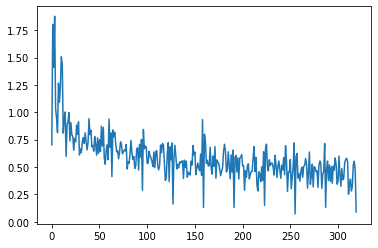

In [765]:
plt.plot(history['train_loss'])

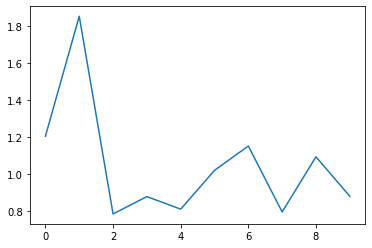

In [766]:
plt.plot(history['val_loss'])

In [326]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [327]:
!ls

dfdc-EfficientNet-TF.ipynb logs


In [328]:
!python3 -m tensorboard.main --logdir=./logs/

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# Clustering

In [733]:
# get train features
c_model = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features=[]
for x, y in train_ds:
    x, y = train_process(x, y)
    train_features.append(c_model(x).numpy())
    
train_features = np.vstack(train_features)

print(train_features.shape)

(100, 1792)


In [734]:
# get val features
for x, y in val_ds:
    x, y = train_process(x, y)
    val_features = c_model(x)
    print(val_features.shape)

(10, 1792)


In [735]:
# get all features
features = np.vstack([train_features, val_features])
features.shape

(110, 1792)

In [744]:
# Clustering
clusters = []
labels = []
pp = range(10, 20)
for c in pp:
    kmeans = KMeans(n_clusters=c, random_state=0)
    a = kmeans.fit(features)
    clusters.append(a.inertia_)
    labels.append(a.labels_)
clusters = np.hstack(clusters)
labels = np.vstack(labels)
print(clusters.shape)
print(labels.shape)

(10,)
(10, 110)


Text(0, 0.5, 'Inertia')

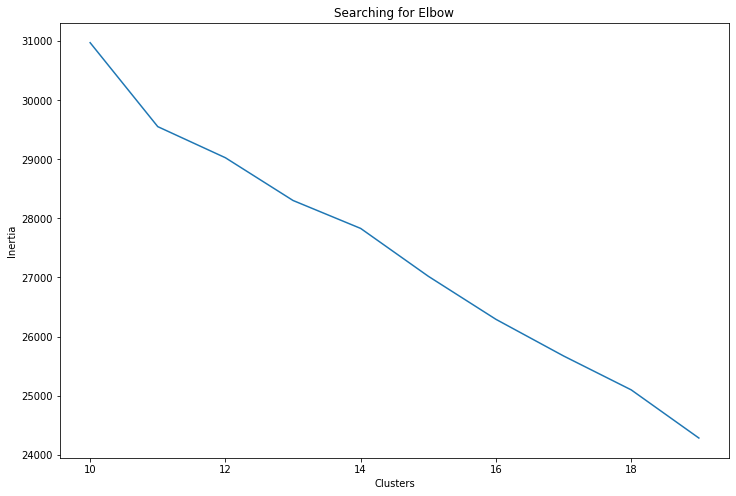

In [745]:
# find suitable clusters
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(pp), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

In [746]:
# train
train_l = np.unique(labels[-1][10:])
train_l

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int32)

In [747]:
# val
val_l = np.unique(labels[-1][:10])
val_l

array([ 0,  1,  2,  3,  4, 12, 13, 17], dtype=int32)

In [748]:
# difference(train-val)
set(val_l) - set(train_l)

set()

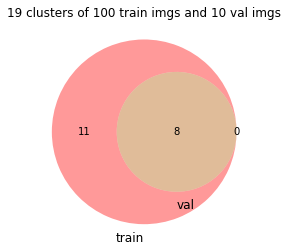

In [749]:
# draw the venn diagram
from matplotlib_venn import venn2
v = venn2([set(train_l), set(val_l)], set_labels=['train', 'val'])
plt.title("{} clusters of {} train imgs and {} val imgs".format(kmeans.n_clusters, train_features.shape[0], val_features.shape[0]))
plt.show()

- check whether the loss is caculated correctly
- check each step